In [1]:
from datascience import *
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def fitted_values(t, x, y):
    """Return an array of the regression estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

def residuals(t, x, y):
    """Return an array of all the residuals"""
    predictions = fitted_values(t, x, y)
    return t.column(y) - predictions

## Residuals

In [3]:
dugong = Table.read_table('dugong.csv')
dugong.show(3)

Length,Age
1.8,1
1.85,1.5
1.87,1.5


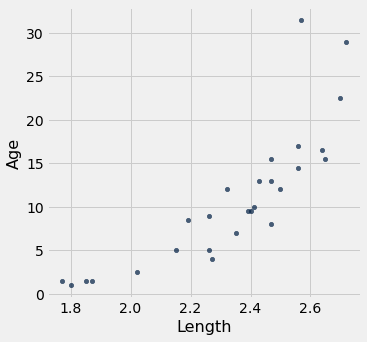

In [4]:
dugong.scatter('Length', 'Age')

In [5]:
correlation(dugong, 'Length', 'Age')

0.82964745549057139

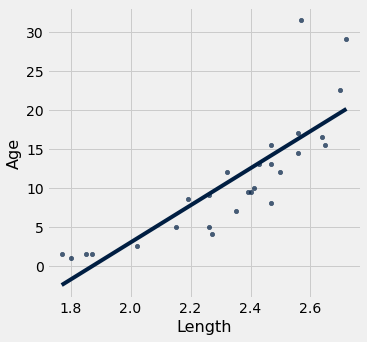

In [6]:
dugong.scatter('Length', 'Age', fit_line=True)

In [7]:
dugong = dugong.with_columns(
    'Predicted Age', fitted_values(dugong, 'Length', 'Age'),
    'Residual', residuals(dugong, 'Length', 'Age')
)

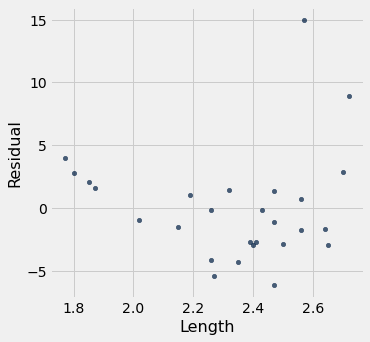

In [8]:
dugong.scatter('Length', 'Residual')

In [9]:
round(np.average(dugong.column('Residual')), 6)

0.0

In [10]:
round(correlation(dugong, 'Length', 'Residual'), 6)

0.0

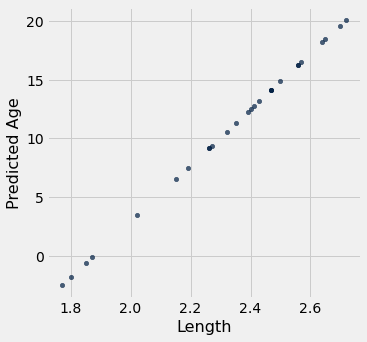

In [11]:
dugong.scatter('Length', 'Predicted Age')

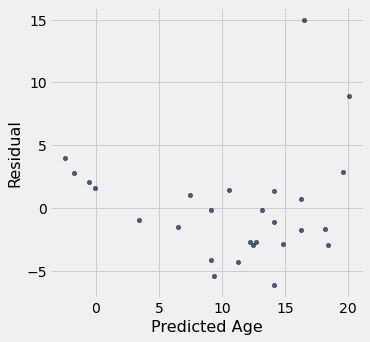

In [12]:
dugong.scatter('Predicted Age', 'Residual')

In [13]:
round(correlation(dugong, 'Predicted Age', 'Residual'), 6)

0.0

## Regression Model

In [14]:
# Ignore this code; it's graphics for demonstrating the regression model
def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    sample.scatter('x', 'y')
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    sample.scatter('x', 'y')
    plots.title('What We Get to See')

    sample.scatter('x', 'y', fit_line=True)
    plots.title('Regression Line: Estimate of True Line')

    sample.scatter('x', 'y', fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")

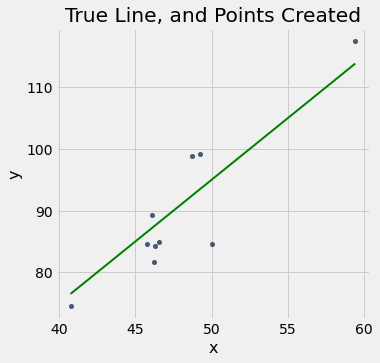

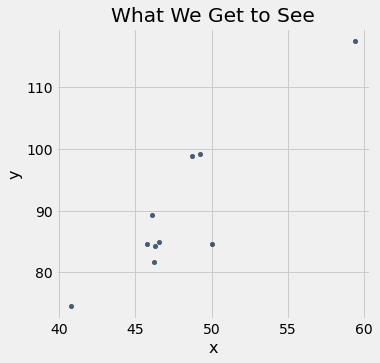

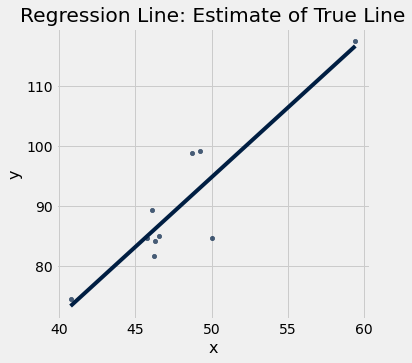

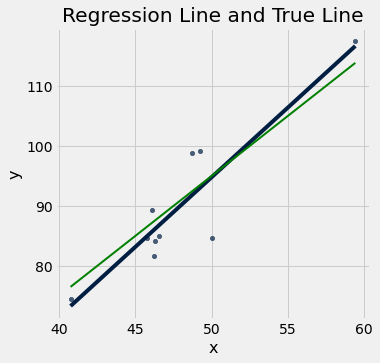

In [15]:
draw_and_compare(2, -5, 10)

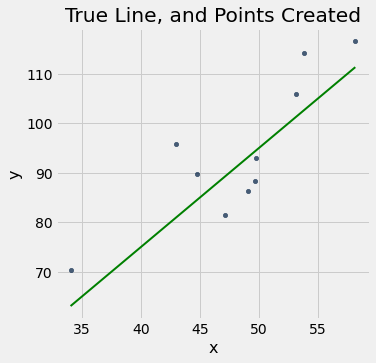

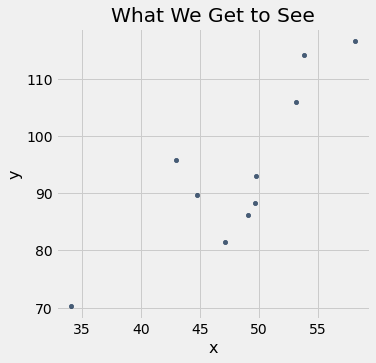

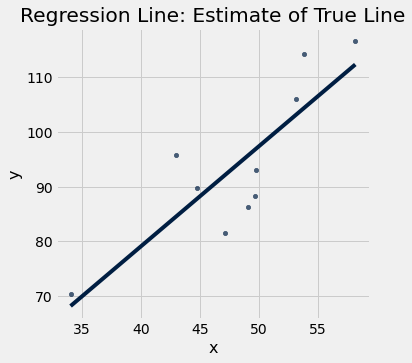

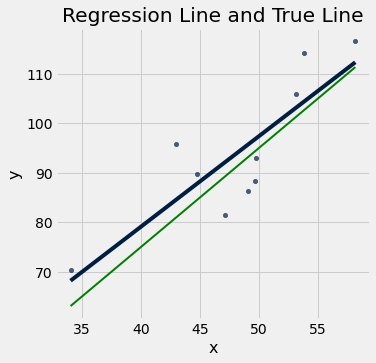

In [16]:
draw_and_compare(2, -5, 10)

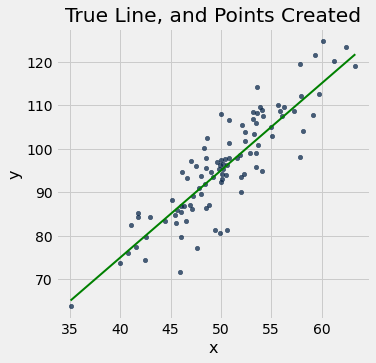

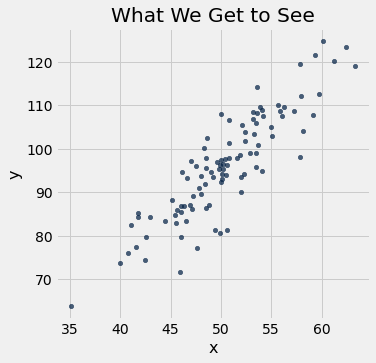

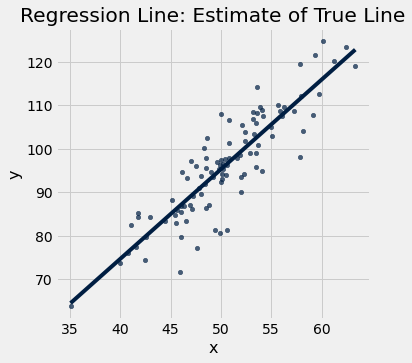

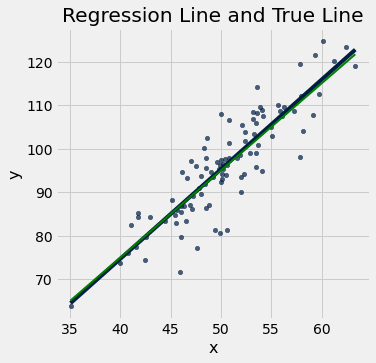

In [17]:
draw_and_compare(2, -5, 100)

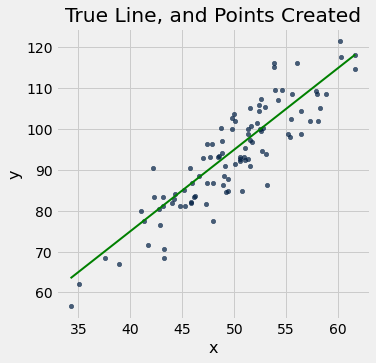

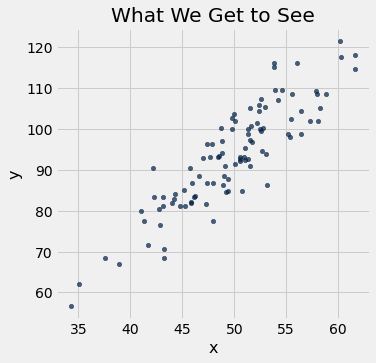

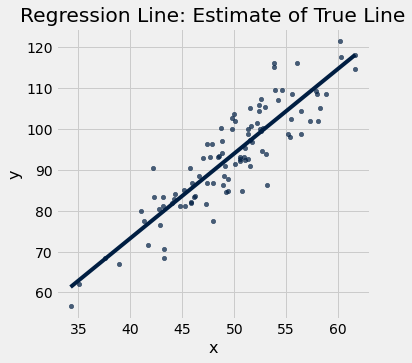

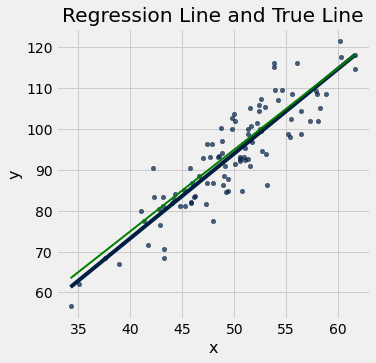

In [18]:
draw_and_compare(2, -5, 100)

## Prediction

In [19]:
births = Table.read_table('baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


In [20]:
# Preterm and postterm pregnancy cutoffs, according to the CDC
37 * 7, 42 * 7

(259, 294)

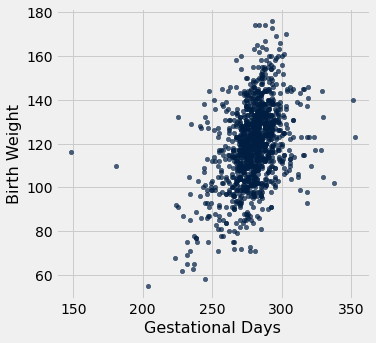

In [21]:
births.scatter('Gestational Days', 'Birth Weight')

In [22]:
births = births.where('Gestational Days', are.between(225, 325))

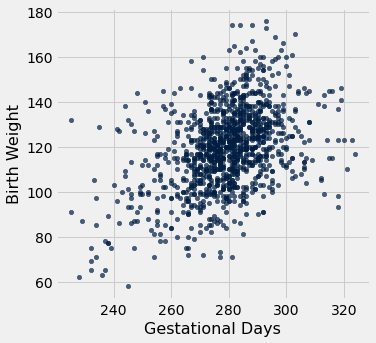

In [23]:
births.scatter('Gestational Days', 'Birth Weight')

## Suppose we assume the regression model

In [24]:
correlation(births, 'Gestational Days', 'Birth Weight')

0.42295118452423991

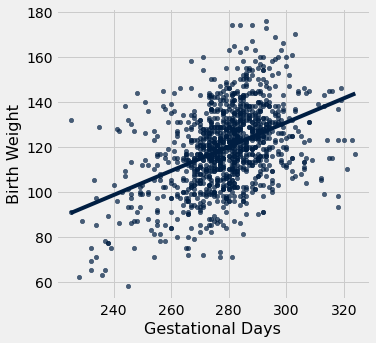

In [25]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

## Prediction at a Given Value of x

In [26]:
def prediction_at(t, x, y, x_value):
    '''
    t - table
    x - label of x column
    y - label of y column
    x_value - the x value for which we want to predict y
    '''
    return slope(t, x, y) * x_value + intercept(t, x, y)

In [27]:
prediction_at_300 = prediction_at(births, 'Gestational Days', 'Birth Weight', 300)
prediction_at_300

130.80951674248769

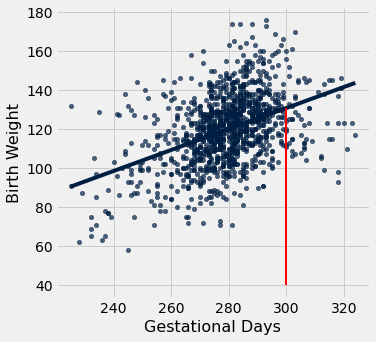

In [28]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.plot([x, x], [40, prediction_at_300], color='red', lw=2);

## Bootstrapping the Sample

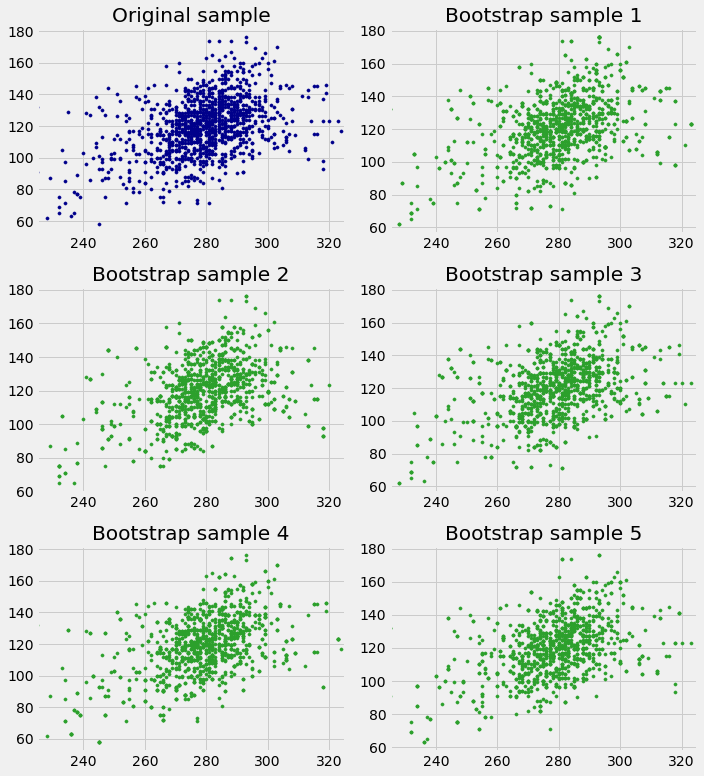

In [29]:
# You don't need to understand the plotting code in this cell,
# but you should understand the figure that comes out.

plots.figure(figsize=(10, 11))
plots.subplot(3, 2, 1)
plots.scatter(births[1], births[0], s=10, color='darkblue')
plots.xlim([225, 325])
plots.title('Original sample')

for i in np.arange(1, 6, 1):
    plots.subplot(3,2,i+1)
    resampled = births.sample()
    plots.scatter(resampled.column('Gestational Days'), resampled.column('Birth Weight'), s=10, color='tab:green')
    plots.xlim([225, 325])
    plots.title('Bootstrap sample '+str(i))
plots.tight_layout()

Predicted y from bootstramp sample was 128.632823114
Predicted y from bootstramp sample was 131.948966292
Predicted y from bootstramp sample was 128.701338307
Predicted y from bootstramp sample was 130.113145576


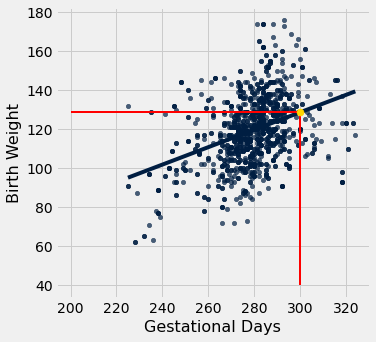

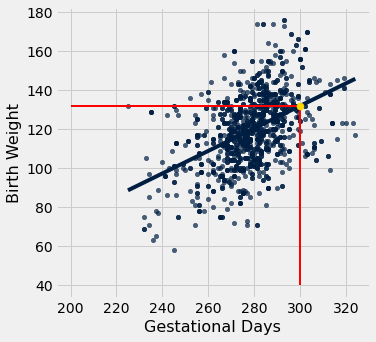

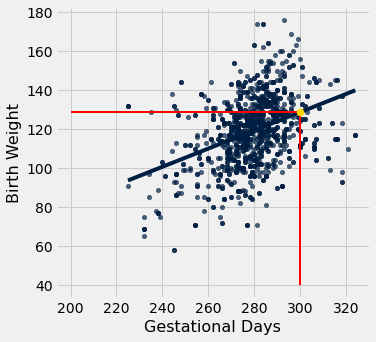

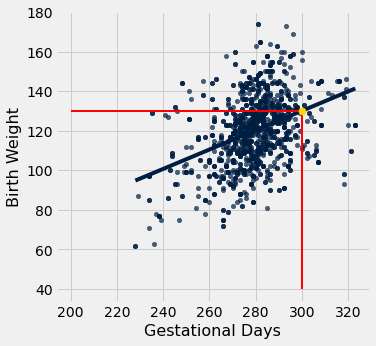

In [30]:
for i in np.arange(4):
    resample = births.sample()
    predicted_y = prediction_at(resample, 'Gestational Days', 'Birth Weight', 300)
    print('Predicted y from bootstramp sample was', predicted_y)
    resample.scatter('Gestational Days', 'Birth Weight', fit_line=True)
    plots.scatter(300, predicted_y, color='gold', s=50, zorder=3);
    plots.plot([x, x], [40, predicted_y], color='red', lw=2);
    plots.plot([200, x], [predicted_y, predicted_y], color='red', lw=2);

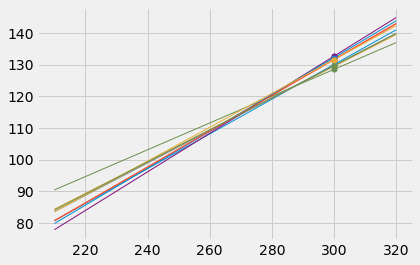

In [31]:
lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

In [32]:
np.mean(births.column('Gestational Days')), np.mean(births.column('Birth Weight'))

(279.11015490533561, 119.57401032702238)

In [33]:
lines = Table(['slope','intercept', 'at 291', 'at 300', 'at 309'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 291 + b, a * 300 + b, a * 309 + b])
lines


slope,intercept,at 291,at 300,at 309
0.472074,-12.092,125.282,129.53,133.779
0.462727,-9.54776,125.106,129.27,133.435
0.523879,-25.6382,126.811,131.525,136.24
0.515268,-25.1729,124.77,129.407,134.045
0.557827,-36.1284,126.199,131.22,136.24
0.568659,-39.2017,126.278,131.396,136.514
0.495479,-18.8589,125.325,129.785,134.244
0.492182,-17.4036,125.821,130.251,134.681
0.537814,-29.946,126.558,131.398,136.238
0.555852,-35.4757,126.277,131.28,136.282


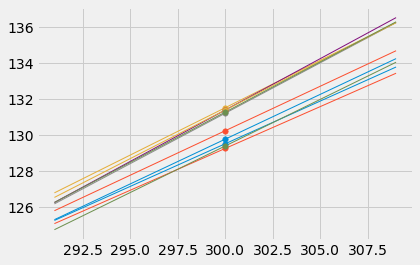

In [34]:
for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([291, 309], [line.item('at 291'), line.item('at 309')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

## Prediction Interval

In [35]:
def bootstrap_prediction(t, x, y, new_x, repetitions=2500):
    """ 
    Makes a 95% confidence interval for the height of the true line at new_x, 
    using linear regression on the data in t (column names x and y).
    Shows a histogram of the bootstrap samples and shows the interval
    in gold.
    """

    # Bootstrap the scatter, predict, collect
    predictions = make_array()
    for i in np.arange(repetitions):
        resample = t.sample()
        predicted_y = prediction_at(resample, x, y, new_x)
        predictions = np.append(predictions, predicted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)
    round_left = round(left, 3)
    round_right = round(right, 3)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval for height of true line at x =', new_x)
    print(round_left, 'to', round_right, '( width =', round(right - left, 3), ')') 

Approximate 95%-confidence interval for height of true line at x = 300
128.882 to 132.761 ( width = 3.879 )


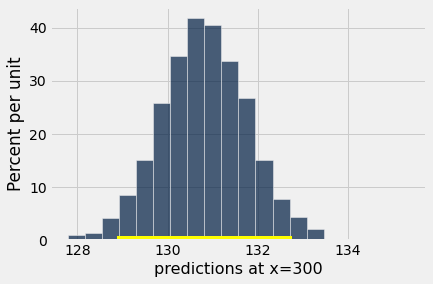

In [36]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 300)

## Predictions at Different Values of x

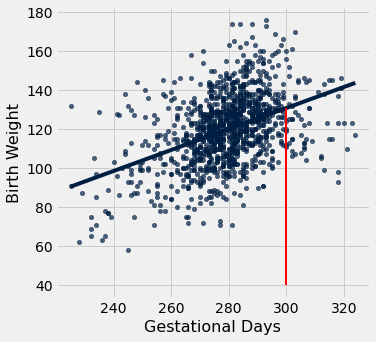

In [37]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.plot([x, x], [40, prediction_at_300], color='red', lw=2);

Approximate 95%-confidence interval for height of true line at x = 230
89.392 to 97.105 ( width = 7.713 )


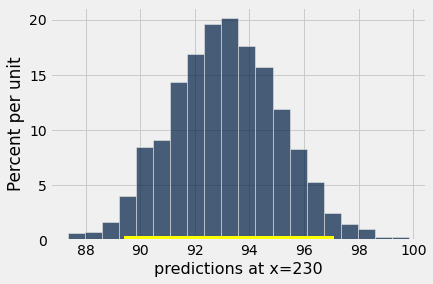

In [38]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 230)

Approximate 95%-confidence interval for height of true line at x = 280
119.071 to 121.031 ( width = 1.96 )


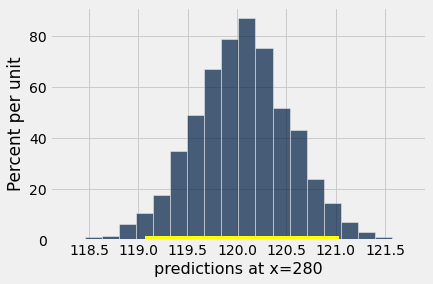

In [39]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 280)

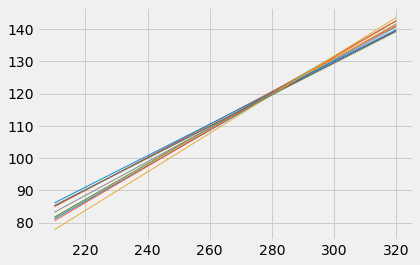

In [40]:
# No need to follow the code in this cell; just understand the graph

lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)

## Inference for the True Slope

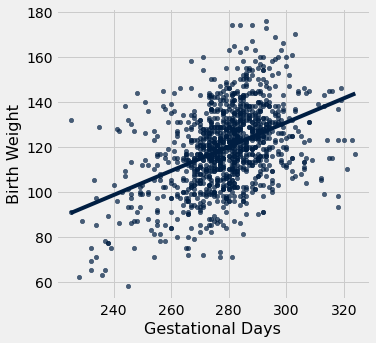

In [41]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [42]:
slope(births, 'Gestational Days', 'Birth Weight')

0.53784536766790358

In [43]:
def bootstrap_slope(t, x, y, repetitions=2500):
    """ 
    Makes a 95% confidence interval for the slope of the true line, 
    using linear regression on the data in t (column names x and y).
    Shows a histogram of the bootstrap samples and shows the interval
    in gold.
    """
    
    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    round_left = round(left, 3)
    round_right = round(right, 3)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(t, x, y)
    
    # Display results (no need to follow this code)
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', round(observed_slope, 3))
    print('Approximate 95%-confidence interval for the slope of the true line:')
    print(round_left, 'to', round_right)

Slope of regression line: 0.538
Approximate 95%-confidence interval for the slope of the true line:
0.459 to 0.62


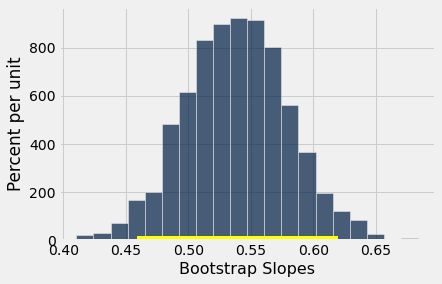

In [44]:
bootstrap_slope(births, 'Gestational Days', 'Birth Weight')

## Rain on the Regression Parade

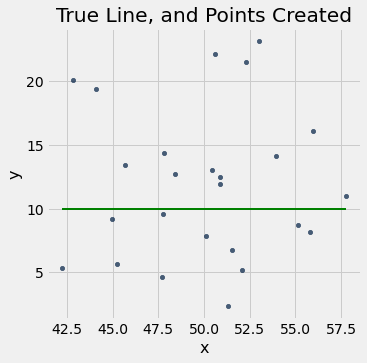

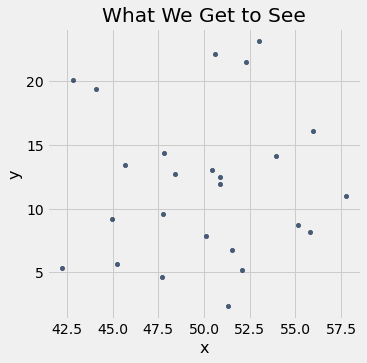

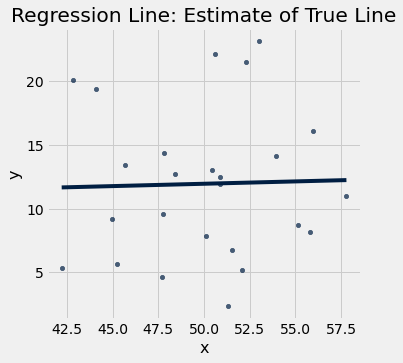

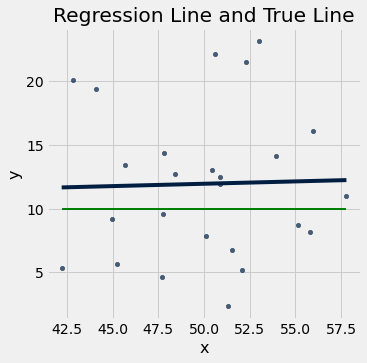

In [45]:
draw_and_compare(0, 10, 25)

### Maternal Age and Birth Weight

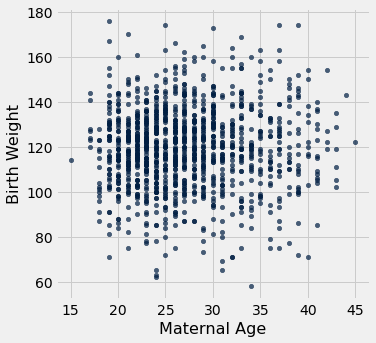

In [46]:
births.scatter('Maternal Age', 'Birth Weight')

In [47]:
slope(births, 'Maternal Age', 'Birth Weight')

0.095142237298344659

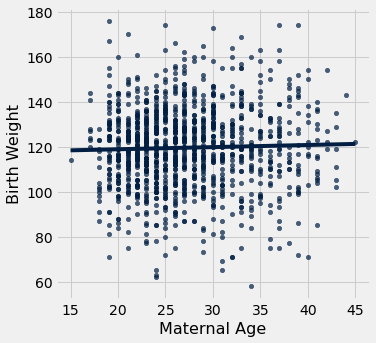

In [48]:
births.scatter('Maternal Age', 'Birth Weight', fit_line=True)

**Null:** Slope of true line is equal to 0.

**Alternative:** Slope of true line is not equal to 0.

Slope of regression line: 0.095
Approximate 95%-confidence interval for the slope of the true line:
-0.09 to 0.276


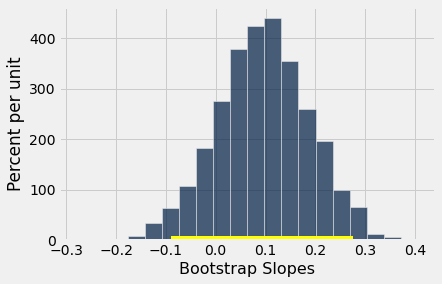

In [49]:
bootstrap_slope(births, 'Maternal Age', 'Birth Weight')